In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Data Loading and Dataset Overview
In this section, we load the dataset and provide an overview of its structure. This data contains information about students' demographics, education, and job placement status, which we will use for further analysis. We will also summarize the dataset to understand data types, non-null counts, and overall structure, helping us prepare for further processing.


In [150]:
#load dataset and data dictionary
df = pd.read_csv('Job Placement_data.csv')
data_descr = pd.read_excel('Data description.xlsx')

In [151]:
print("Data Description")
print(data_descr)

Data Description
            Column                                   Explanation
0            sl_no                                 Serial Number
1           gender                                  Gender (M/F)
2            ssc_p                Secondary Education percentile
3            ssc_b                            Board of Education
4            hsc_p         Higher Secondary Education percentile
5            hsc_b           Board of Education- Central/ Others
6            hsc_s  Specialization in Higher Secondary Education
7         degree_p                             Degree Percentile
8         degree_t                 Under Graduation(Degree type)
9           workex                               Work Experience
10         etest_p                 Employability test percentile
11  specialisation                           Area of speciality 
12           mba_p                                MBA percentile
13          Salary                         Salary of job offered
14      

In [152]:
print('Data Info:')
print(df.info())
print('Data Head:')
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           213 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           214 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  214 non-null    object 
 12  mba_p           215 non-null    float64
 13  salary          148 non-null    float64
 14  status          215 non-null    object 
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB
None
Data Head:
   sl_no gender  ssc_p    ssc_b  hsc_p  

## Checking for Missing Values
Here, we check for any missing values across the columns to determine the extent of data cleaning required.


In [158]:
print("Check for missing values:")
print(df.isnull().sum())

Check for missing values:
sl_no              0
gender             0
ssc_p              0
ssc_b              0
hsc_p              2
hsc_b              0
hsc_s              1
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     1
mba_p              0
salary            67
status             0
dtype: int64


## Handling Missing Values
We handle missing values in the dataset to avoid biases. Numeric values like `hsc_p` are filled using the median, while categorical values are filled using the mode.

In [161]:
df['hsc_p'] = df['hsc_p'].fillna(df['hsc_p'].median())

In [163]:
for column in ['hsc_s', 'specialisation']:
    df[column] = df[column].fillna(df[column].mode()[0])

In [165]:
median_salary_placed = df[df['status'] == 'Placed']['salary'].median()
df['salary'] = df['salary'].fillna(median_salary_placed)

In [167]:
print("Missing values handled") 
print(df.isnull().sum())

Missing values handled
sl_no             0
gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
salary            0
status            0
dtype: int64


In [169]:
print("DataFrame info after removing missing values:")
print(df.info())

DataFrame info after removing missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  salary          215 non-null    float64
 14  status          215 non-null    object 
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB
None


## Outlier Detection
To ensure that our analysis is not skewed by extreme values, we calculate outliers using the Interquartile Range (IQR) method for numerical columns.

In [183]:
#Handling Outliers by identifying with IQR
# Function to calculate IQR-based outliers
def calculate_iqr_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.0 * IQR  # Using 2.0 as the adjusted multiplier
    upper_bound = Q3 + 2.0 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

numeric_columns = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary']

# Dictionary to store outlier information for each column
outliers_info = {}
for column in numeric_columns:
    outliers, lower_bound, upper_bound = calculate_iqr_outliers(df, column)
    outliers_info[column] = {
        "outliers": outliers,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }

# Summarize outlier details in a table
outliers_summary = {key: {
    "Number of Outliers": len(value["outliers"]),
    "Lower Bound": value["lower_bound"],
    "Upper Bound": value["upper_bound"]
} for key, value in outliers_info.items()}

# Display the summary of outliers
import pandas as pd
pd.DataFrame(outliers_summary).transpose()

,Number of Outliers,Lower Bound,Upper Bound
ssc_p,0.0,24.84,103.44
hsc_p,5.0,40.00,90.00
degree_p,0.0,40.00,90.00
etest_p,0.0,24.00,114.00
mba_p,0.0,41.06,81.51
salary,0.0,220000.00,295000.00


## Removing Outliers
After identifying the outliers, we then filter them out of the dataset to ensure our model is trained on representative data.


In [194]:
# Remove outliers from the dataset
for column in numeric_columns:
    _, lower_bound, upper_bound = calculate_iqr_outliers(df, column)
df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df.shape

(140, 15)

# Data Visualization
We visualize various features of the dataset to explore relationships between educational scores and placement status. This helps us understand how different factors impact the probability of getting placed.


## Distribution of Secondary Education Scores by Placement Status
This histogram illustrates the distribution of secondary education percentage scores (`ssc_p`) for students, categorized by their placement status. It helps us understand how academic performance at the secondary level impacts job placements.


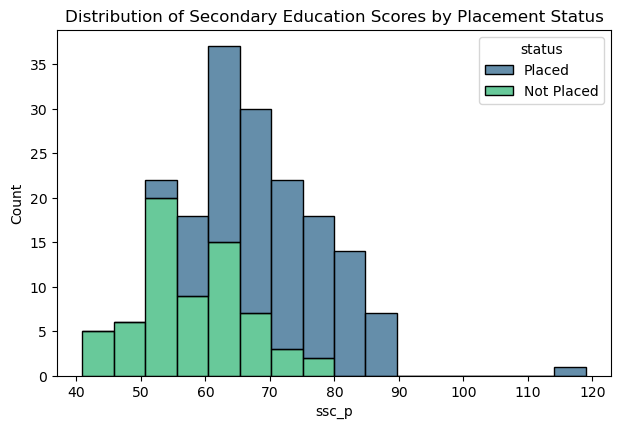

In [101]:
#Visulizations on graduates and summary level charts/graphs
plt.figure(figsize=(12, 8))
#Educational scores distribution
plt.subplot(2, 2, 1)
sns.histplot(df, x='ssc_p',hue='status', multiple='stack', palette='viridis')
plt.title('Distribution of Secondary Education Scores by Placement Status')

plt.tight_layout()
plt.show()

## Distribution of Higher Secondary Education Scores by Placement Status
This histogram shows the distribution of higher secondary education percentage scores (`hsc_p`) for students. It provides insights into whether higher academic performance correlates with better placement outcomes.


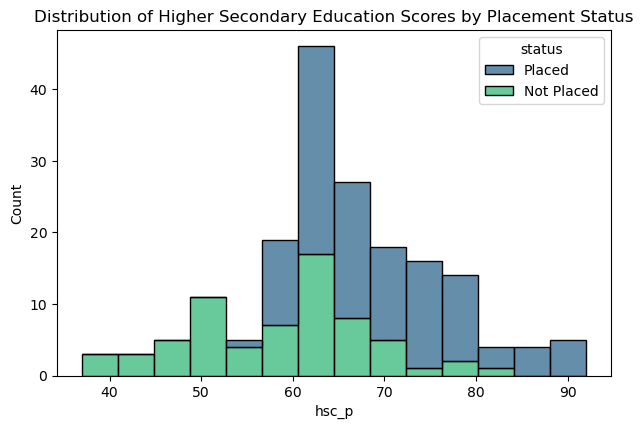

In [103]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
sns.histplot(df, x='hsc_p', hue='status', multiple='stack', palette='viridis')
plt.title('Distribution of Higher Secondary Education Scores by Placement Status')

plt.tight_layout()
plt.show()

## Gender Distribution Among Placed Graduates
This pie chart visualizes the gender distribution of students who successfully secured job placements. By analyzing this, we can observe if there are any gender-related trends in placement outcomes.


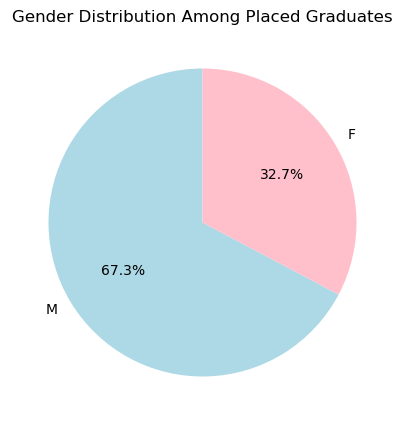

In [105]:
gender_counts = df[df['status'] == 'Placed']['gender'].value_counts()
plt.figure(figsize=(7, 5))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Gender Distribution Among Placed Graduates')
plt.ylabel('')  
plt.show()

## Specialization and Placement Status
This bar chart examines the number of graduates from different specializations (e.g., Marketing & HR, Marketing & Finance), categorized by placement status. It provides insights into whether specific specializations lead to higher placement success.


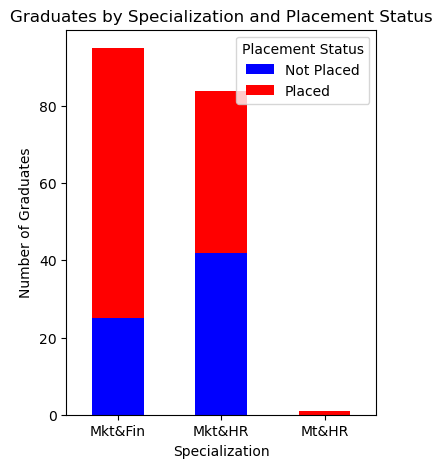

In [107]:
#Specialized and Placement Status
specialized_p_counts = df.groupby(['specialisation', 'status'])['sl_no'].count().unstack()
specialized_p_counts.plot (kind='bar', stacked=True, figsize=(4, 5), color=['b', 'r'])
plt.title('Graduates by Specialization and Placement Status')
plt.xlabel('Specialization')
plt.ylabel('Number of Graduates')
plt.xticks(rotation=0)
plt.legend(title='Placement Status', loc='upper right')
plt.show()

## Degree Percentile Distribution by Placement Status
This bar chart shows the degree percentage scores grouped into bins and categorized by placement status. It helps identify whether higher degree scores are associated with better placement opportunities.


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Figure size 1200x700 with 0 Axes>

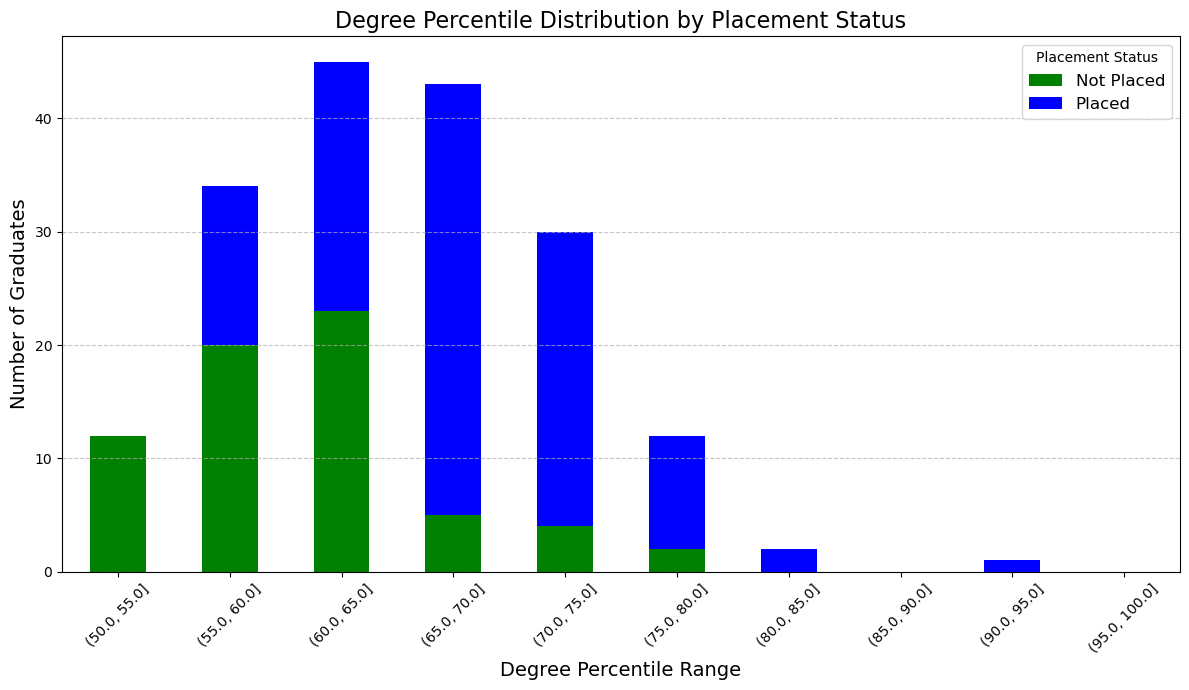

In [110]:
# Create bins for 'degree_p' with values between 50 and 100
df['degree_p_bin'] = pd.cut(df['degree_p'], bins=np.linspace(50, 100, 11))

# Group by the new bins and 'status', then count the occurrences
degree_bin_counts = df.groupby(['degree_p_bin', 'status']).size().unstack(fill_value=0)

# Create the figure and plot
plt.figure(figsize=(12, 7))
degree_bin_counts.plot(kind='bar', stacked=True, color=['g', 'b'], figsize=(12, 7))

# Add title and labels
plt.title('Degree Percentile Distribution by Placement Status', fontsize=16)
plt.xlabel('Degree Percentile Range', fontsize=14)
plt.ylabel('Number of Graduates', fontsize=14)

# Rotate x-tick labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Placement Status', loc='upper right', fontsize=12)

# Enable grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Average Academic Scores by Placement Status
This bar chart visualizes the average secondary and higher secondary scores of students, grouped by their placement status. It helps determine if academic performance significantly impacts job placement.


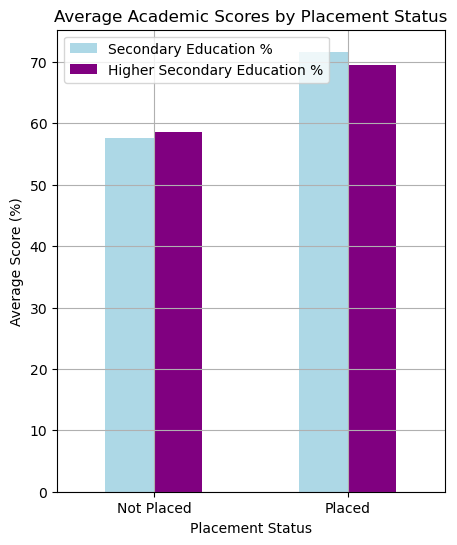

In [112]:
academic_scores_grp = df.groupby('status')[['ssc_p', 'hsc_p']].mean()

academic_scores_grp.plot(kind='bar', figsize=(5, 6), color=['lightblue', 'purple'])
plt.title('Average Academic Scores by Placement Status')
plt.xlabel('Placement Status')
plt.ylabel('Average Score (%)')
plt.xticks(rotation=0)
plt.legend(['Secondary Education %', 'Higher Secondary Education %'])
plt.grid(True)
plt.show()

## MBA Percentile and Placement Rates
This bar chart analyzes MBA percentage scores grouped into ranges and their corresponding placement status. It examines whether students with higher MBA scores are more likely to be placed.


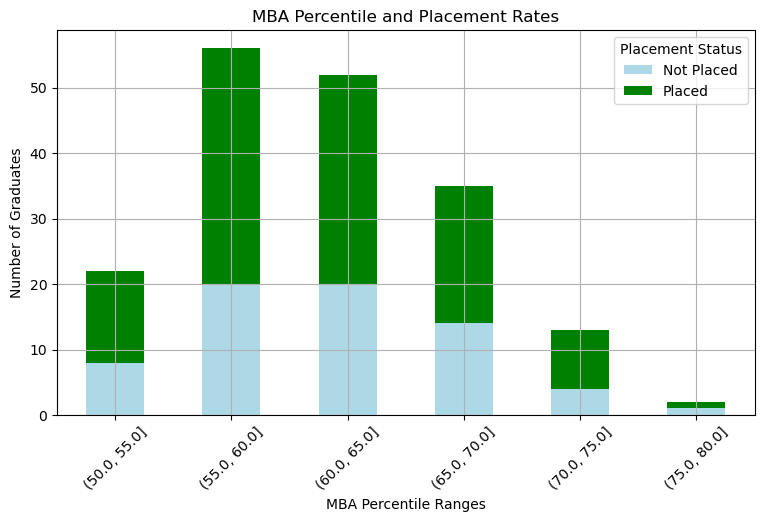

In [114]:
df['mba_p_bin'] = pd.cut(df['mba_p'], bins=np.linspace(50, 80, 7))
mba_grad_job = df.groupby(['mba_p_bin', 'status'], observed=False).size().unstack(fill_value=0)
mba_grad_job.plot(kind='bar', stacked=True, figsize=(9, 5), color=['lightblue', 'g'])
plt.title('MBA Percentile and Placement Rates')
plt.xlabel('MBA Percentile Ranges')
plt.ylabel('Number of Graduates')
plt.xticks(rotation=45)
plt.legend(title='Placement Status')
plt.grid(True)

## Specialization Impact on Career Placement
This pie chart shows the distribution of students across specializations among those who were placed. It helps identify which specializations are more likely to lead to successful job placements.


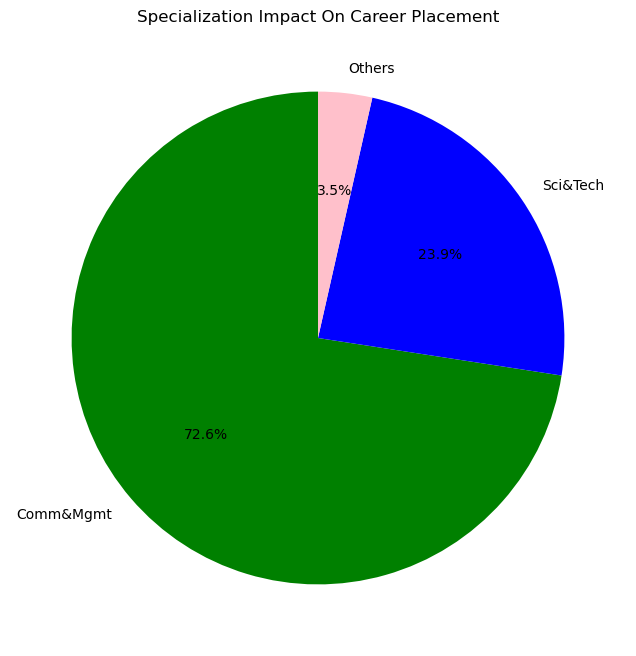

In [116]:
specicilization_and_degree = df[df['status'] == 'Placed']['degree_t'].value_counts()
plt.figure(figsize=(8, 8))
specicilization_and_degree.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'pink'])
plt.title('Specialization Impact On Career Placement')
plt.ylabel('')
plt.show(close=all, block=all)

## Analysis of the Dataset So Far
In this section, we summarize the dataset to understand:
- The types of variables (numerical and categorical).
- The overall completeness of the data.
- The first few rows for structural clarity.
This lays the groundwork for the upcoming data preparation and modeling steps.


In [118]:
print('Data Info:')
print(df.info())
print('Data Head:')
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 214
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sl_no           180 non-null    int64   
 1   gender          180 non-null    object  
 2   ssc_p           180 non-null    float64 
 3   ssc_b           180 non-null    object  
 4   hsc_p           180 non-null    float64 
 5   hsc_b           180 non-null    object  
 6   hsc_s           180 non-null    object  
 7   degree_p        180 non-null    float64 
 8   degree_t        180 non-null    object  
 9   workex          180 non-null    object  
 10  etest_p         180 non-null    float64 
 11  specialisation  180 non-null    object  
 12  mba_p           180 non-null    float64 
 13  salary          180 non-null    float64 
 14  status          180 non-null    object  
 15  degree_p_bin    179 non-null    category
 16  mba_p_bin       180 non-null    category
dtypes: categor

### Checking for Missing Values
Missing values in the dataset are identified to assess the extent of data cleaning required. This step ensures that our analysis and models are not biased or skewed by incomplete data.

In [120]:
print(df.isnull().sum())

sl_no             0
gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
salary            0
status            0
degree_p_bin      1
mba_p_bin         0
dtype: int64


### Drop the Bins and Missing Values

In [122]:
df = df.drop(['degree_p_bin','mba_p_bin'], axis=1)

In [123]:
#Check The Updated Dataframe and Missing Values
print("Missing Value Analysis")
print(df.isnull().sum())
print("Updated DataFrame:")
print(df.info)

Missing Value Analysis
sl_no             0
gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
salary            0
status            0
mba_p_bin         0
dtype: int64
Updated DataFrame:
<bound method DataFrame.info of      sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0        1      M   67.0   Others   91.0   Others  Commerce     58.00   
2        3      M   65.0  Central   68.0  Central      Arts     64.00   
3        4      M   56.0  Central   52.0  Central   Science     52.00   
5        6      M   55.0   Others   49.8   Others   Science     67.25   
6        7      F   46.0   Others   49.2   Others  Commerce     79.00   
..     ...    ...    ...      ...    ...      ...       ...       ...   
209    210      M   62.0  Central   72.0  Central  Commerce     65.00   
211    212      M   58.0   Ot

### Preparing The Data For The Regression Analysis

In [125]:
categorical_var = ['gender','ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'status', 'specialisation']
df_en = pd.get_dummies(df, columns=categorical_var, drop_first=True)

In [126]:
print("Data after encoding:")
print(df_en.head())

Data after encoding:
   sl_no  ssc_p  hsc_p  degree_p  etest_p    salary     mba_p_bin  gender_M  \
0      1   67.0   91.0     58.00    55.00  270000.0  (55.0, 60.0]      True   
2      3   65.0   68.0     64.00    75.00  250000.0  (55.0, 60.0]      True   
3      4   56.0   52.0     52.00    66.00  265000.0  (55.0, 60.0]      True   
5      6   55.0   49.8     67.25    55.00  265000.0  (50.0, 55.0]      True   
6      7   46.0   49.2     79.00    74.28  265000.0  (50.0, 55.0]     False   

   ssc_b_Others  hsc_b_Others  hsc_s_Commerce  hsc_s_Science  degree_t_Others  \
0          True          True            True          False            False   
2         False         False           False          False            False   
3         False         False           False           True            False   
5          True          True           False           True            False   
6          True          True            True          False            False   

   degree_t_Sci&T

### Preparing The Model To Be Used During Training and Testing


In [128]:
X = df_en
X = X.drop(['salary'], axis=1)
y = df_en['status_Placed']

### Spliting The Data to Training and Testing Set

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [142]:
# Display the data types of each column
print(X_train.dtypes


sl_no                       int64
ssc_p                     float64
hsc_p                     float64
degree_p                  float64
etest_p                   float64
mba_p_bin                category
gender_M                     bool
ssc_b_Others                 bool
hsc_b_Others                 bool
hsc_s_Commerce               bool
hsc_s_Science                bool
degree_t_Others              bool
degree_t_Sci&Tech            bool
workex_Yes                   bool
status_Placed                bool
specialisation_Mkt&HR        bool
specialisation_Mt&HR         bool
dtype: object


In [196]:
# Drop irrelevant columns
X_train = X_train.drop(['sl_no'], axis=1)
X_test = X_test.drop(['sl_no'], axis=1)


In [198]:
# Convert categorical column 'mba_p_bin' to numeric
X_train = pd.get_dummies(X_train, columns=['mba_p_bin'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['mba_p_bin'], drop_first=True)

# Ensure alignment of training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_test = X_test.fillna(0)  # Fill missing columns with 0


In [200]:
# Convert boolean columns to integers
bool_columns = X_train.select_dtypes(include=['bool']).columns
X_train[bool_columns] = X_train[bool_columns].astype(int)
X_test[bool_columns] = X_test[bool_columns].astype(int)


In [202]:
# Check for missing values
print(X_train.isnull().sum())
print(X_test.isnull().sum())

# Fill any remaining missing values if necessary
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


ssc_p                     0
hsc_p                     0
degree_p                  0
etest_p                   0
gender_M                  0
ssc_b_Others              0
hsc_b_Others              0
hsc_s_Commerce            0
hsc_s_Science             0
degree_t_Others           0
degree_t_Sci&Tech         0
workex_Yes                0
status_Placed             0
specialisation_Mkt&HR     0
specialisation_Mt&HR      0
mba_p_bin_(55.0, 60.0]    0
mba_p_bin_(60.0, 65.0]    0
mba_p_bin_(65.0, 70.0]    0
mba_p_bin_(70.0, 75.0]    0
mba_p_bin_(75.0, 80.0]    0
dtype: int64
ssc_p                     0
hsc_p                     0
degree_p                  0
etest_p                   0
gender_M                  0
ssc_b_Others              0
hsc_b_Others              0
hsc_s_Commerce            0
hsc_s_Science             0
degree_t_Others           0
degree_t_Sci&Tech         0
workex_Yes                0
status_Placed             0
specialisation_Mkt&HR     0
specialisation_Mt&HR      0
mba_p_b

In [208]:
# Verify data types
print(X_train.dtypes)

ssc_p                     float64
hsc_p                     float64
degree_p                  float64
etest_p                   float64
gender_M                    int64
ssc_b_Others                int64
hsc_b_Others                int64
hsc_s_Commerce              int64
hsc_s_Science               int64
degree_t_Others             int64
degree_t_Sci&Tech           int64
workex_Yes                  int64
status_Placed               int64
specialisation_Mkt&HR       int64
specialisation_Mt&HR        int64
mba_p_bin_(55.0, 60.0]      int64
mba_p_bin_(60.0, 65.0]      int64
mba_p_bin_(65.0, 70.0]      int64
mba_p_bin_(70.0, 75.0]      int64
mba_p_bin_(75.0, 80.0]      int64
dtype: object


### Create Logistic Regression Object

In [238]:
# Initialize and train the logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### **Goal**: Predict Whether a Graduate Will Receive a Job Offer Based on Their Academic Performance and Other Factors.

#### Finding Score for Training Data 

In [242]:
# Evaluate the model
training_accuracy = lr.score(X_train, y_train)
print(f"Training Accuracy: {training_accuracy:.2f}")

Training Accuracy: 1.00


### Predictions on The Training Data

In [245]:
pred_train = lr.predict(X_train)
cmtx_train = pd.DataFrame(
    metrics.confusion_matrix(y_train, pred_train),  
    index=['actual:no', 'actual:yes'], 
    columns=['pred:no', 'pred:yes']
    
)

## Training Confusion Matrix
To evaluate the model's predictions on the training data, we generate the confusion matrix as follows:

In [273]:
print("Training Confusion Matrix:")
print(cmtx_train)

Training Confusion Matrix:
            pred:no  pred:yes
actual:no        48         0
actual:yes        0        78


## Confusion Matrix Visualization for Training Model
We visualize the training confusion matrix to better understand the performance of the model using a heatmap:

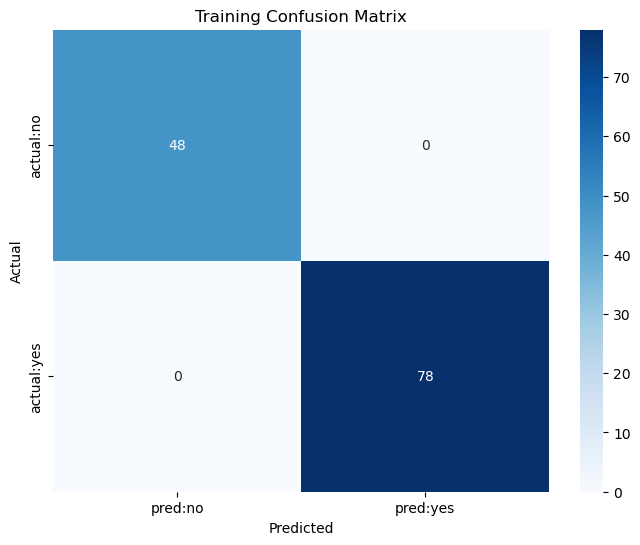

In [275]:
plt.figure(figsize=(8, 6))
sns.heatmap(cmtx_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Predictions on Testing Data
 We use the trained model to predict the outcomes for the testing dataset and visualize the results using a confusion matrix.

In [279]:
pred_test = lr.predict(X_test)

In [281]:
testing_accuracy = lr.score(X_test, y_test)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

Testing Accuracy: 0.93


### Confusion Matrix Dataframe For Testing Data

In [288]:
test_matrix = metrics.confusion_matrix(y_test, pred_test)

cmtx_test = pd.DataFrame(
    test_matrix,
    index=['actual:no', 'actual:yes'], 
    columns=['pred:no', 'pred:yes']
)
print("Testing Confusion Matrix:")
print(cmtx_test)

Testing Confusion Matrix:
            pred:no  pred:yes
actual:no        18         1
actual:yes        3        32


## Confusion Matrix Visualization for Testing Model
The confusion matrix for the testing model can be visualized as a heatmap to make it easier to interpret the performance metrics:

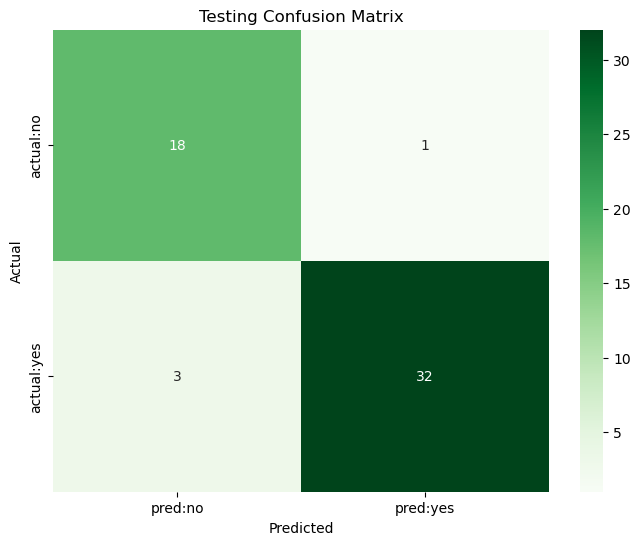

In [291]:
plt.figure(figsize=(8, 6))
sns.heatmap(cmtx_test, annot=True, fmt='d', cmap='Greens')
plt.title('Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()